# Latent Semantic Analysis (LSA)

This notebook is for developing, not implementing a solution.

*Current State*
- Preprocessing was performed for a Bag-of-upto-Ngrams TF-IDF representation. 
- This representation suffers from the curse of dimensionality.
- LSA, in particular, matrix decomposition using SVD, can be used to reduce a document-term matrix to a document-component ("topic") matrix.

*Results*
- SVD reduces accuracy a bit, but makes the dataset a lot smaller.
- The accuracy v. size trande-off might be useful for training computatinally expensive models.

---

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd

import cleanup_module as Cmod

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.decomposition import TruncatedSVD

### Sample 10% of the training data for POC

In [2]:
# load minimally prepared X, y train subsets
raw_path = os.path.join("..","data","1_raw","sentiment140")
X_train = pd.read_csv(os.path.join(raw_path, "X_train.csv"))
y_train = pd.read_csv(os.path.join(raw_path, "y_train.csv"))

# sample for dev
X, X_rest, y, y_rest = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

# create array
X_array = np.array(X.iloc[:, 2]).ravel()
y_array = y.iloc[:,0].ravel()

In [3]:
X_array.shape, y_array.shape

((119747,), (119747,))

### Preprocess with 50,000 features

Using `sublinear_tf=True, use_idf=True` as recommended in [docs.](https://scikit-learn.org/stable/modules/decomposition.html#lsa)

In [4]:
pipe = Pipeline([('counter', Cmod.DocumentToNgramCounterTransformer()),
                 ('bow', Cmod.WordCounterToVectorTransformer(vocabulary_size=50000)),
                 ('tfidf', TfidfTransformer(sublinear_tf=True, use_idf=True))]) # see docs

In [5]:
start_time = time.time()

X_train_transformed = pipe.fit_transform(X_array)

mins, secs = divmod(time.time() - start_time, 60)
print(f'Elapsed: {mins:0.0f} min {secs:0.0f} sec')

Elapsed: 1 min 7 sec


In [6]:
X_train_transformed

<119747x50001 sparse matrix of type '<class 'numpy.float64'>'
	with 2506933 stored elements in Compressed Sparse Row format>

### SVD

Point of departure: [Analytics Vidhya Tutorial](https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/). 

Consulted Prof. Steve Brunton's [YouTube lecture series](https://www.youtube.com/playlist?list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv) and [Data-Driven Science and Engineering book](https://www.amazon.com/Data-Driven-Science-Engineering-Learning-Dynamical/dp/1108422098). 

Using sklearn's **TruncatedSVD** class:

[(source)](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/decomposition/_truncated_svd.py#L24)
```
    def fit_transform(self, X, y=None):
        """Fit LSI model to X and perform dimensionality reduction on X.
        
        [...]
        
        if self.algorithm == "arpack":
            U, Sigma, VT = svds(X, k=self.n_components, tol=self.tol)
            # svds doesn't abide by scipy.linalg.svd/randomized_svd
            # conventions, so reverse its outputs.
            Sigma = Sigma[::-1]
            U, VT = svd_flip(U[:, ::-1], VT[::-1])

        elif self.algorithm == "randomized":
            k = self.n_components
            n_features = X.shape[1]
            if k >= n_features:
                raise ValueError("n_components must be < n_features;"
                                 " got %d >= %d" % (k, n_features))
            U, Sigma, VT = randomized_svd(X, self.n_components,
                                          n_iter=self.n_iter,
                                          random_state=random_state)
        else:
            raise ValueError("unknown algorithm %r" % self.algorithm)

        self.components_ = VT

        # Calculate explained variance & explained variance ratio
        X_transformed = U * Sigma
        
        [...]
        
        self.singular_values_ = Sigma  # Store the singular values.

        return X_transformed

    def transform(self, X):
        """Perform dimensionality reduction on X.
        [...]
        X = check_array(X, accept_sparse=['csr', 'csc'])
        check_is_fitted(self)
        return safe_sparse_dot(X, self.components_.T)
```                                          

Previous runs:

* The randomized algorithm takes too long and arrives at basically the same result.
* 50k features, 300 topics = 75% accuracy, 1000 topics = 77% accuracy

In [7]:
# arpack 
svd_model = TruncatedSVD(n_components=1000, # num topics
                         algorithm='arpack', 
                         n_iter=100, 
                         random_state=42)

In [8]:
start_time = time.time()

svd_model.fit(X_train_transformed)

mins, secs = divmod(time.time() - start_time, 60)
print(f'Elapsed: {mins:0.0f} min {secs:0.0f} sec')

Elapsed: 6 min 41 sec


In [9]:
svd_model.n_features_in_

50001

In [10]:
len(svd_model.components_)

1000

In [11]:
len(svd_model.components_[0])

50001

In [12]:
# look at dims for matrix multiplication
X_train_transformed.shape, svd_model.components_.T.shape

((119747, 50001), (50001, 1000))

In [13]:
from sklearn.utils.extmath import safe_sparse_dot

# transform method in sklearn's docs
svd_model_transf = safe_sparse_dot(X_train_transformed, svd_model.components_.T)

# fitting and transforming as above can also be done together
# svd_model_transf = svd_model.fit_transform(X_train_transformed)

svd_model_transf.shape 

(119747, 1000)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, svd_model_transf, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.0s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.6s finished


accuracy: 0.7758 (+/- 0.0011)


In [15]:
# compare to original X_train_transformed
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.8s


accuracy: 0.7992 (+/- 0.0004)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


### Plotting singular values


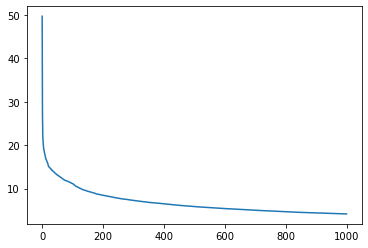

In [16]:
import matplotlib.pyplot as plt

plt.plot(svd_model.singular_values_)
plt.show()

Trying out first 500 to compare speeds.

In [17]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, svd_model_transf[:,:300], y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished


accuracy: 0.7488 (+/- 0.0016)


---

Note: avoid Naive Bayes on SVD since it implies strong independence between variables.

Quoting the [Analytics Vidhya Tutorial](https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/) ~

"*Apart from LSA, there are other advanced and efficient topic modeling techniques such as Latent Dirichlet Allocation (LDA) and lda2Vec. We have a wonderful article on LDA which you can check out [here](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/). lda2vec is a much more advanced topic modeling which is based on word2vec word embeddings.*"